In [95]:
library(OmnipathR)
# library(nichenetr)
library(tidyverse)
library(dplyr)
library(VennDiagram)
library(ggplot2)
library(utils)

```import_ligrecextra_interactions```

link: to documentation <https://r.omnipathdb.org/reference/import_ligrecextra_interactions.html>

This LR dataset contains ligand-receptor interactions without literature reference. The ligand-receptor interactions supported by literature references are part of the `omnipath` dataset.


Default params(without filtering resources) have 8350 edges. The table includes columns as follows. 

'source' 'target' 'source_genesymbol' 'target_genesymbol' 'is_directed' 'is_stimulation' 'is_inhibition' 'consensus_direction' 'consensus_stimulation' 'consensus_inhibition' 'sources' 'references' 'curation_effort' 'n_references' 'n_resources'

**The consensus score is if resources support the classification of an entity into a category based on combined information of many resources.**

| sources                                                         | ref | cur_effort | n_ref | n_source |
|-----------------------------------------------------------------|-----|------------|-------|----------|
|      Baccin2019;CellCall;PhosphoPoint;Ramilowski2015_Baccin2019 | NA  | 0          | 0     | 3        |
| Baccin2019;CellCall;PhosphoPoint;Ramilowski2015_Baccin2019;Wang | NA  | 0          | 0     | 4        |
|                                                                 |     |            |       |          |

```curated_ligand_receptor_interactions```

expert curated ligand-receptor resources, provided by this function




In [96]:
# https://r.omnipathdb.org/reference/curated_ligand_receptor_interactions.html
# curated=curated_ligand_receptor_interactions()
lr <- import_ligrecextra_interactions()
lr <- lr %>% filter(!duplicated(lr[, c("source_genesymbol", "target_genesymbol")]))
curated <- curated_ligand_receptor_interactions()
curated <- curated %>% filter(!duplicated(curated[, c("source_genesymbol", "target_genesymbol")]))

```import_omnipath_intercell``` Imports the OmniPath intercellular **communication role annotation** database. It provides information on the roles in inter-cellular signaling. E.g. if a protein is a ligand, a receptor, an extracellular matrix (ECM) component, etc.

In [97]:
anno_raw <- import_omnipath_intercell()
#subset annotation DB to only ligand and receptors
anno_lig <- anno_raw %>%
    dplyr::filter(category %in% c("receptor","ligand"))
# Drop rows where the values in the "parent", "database", and "uniprot" columns are duplicated
anno_raw <- anno_raw %>% filter(!duplicated(anno_raw[, c("parent", "database", "uniprot")]))

# Breaking down complexes

Below, we produce all the the possible pairs. 

Example: lets assume complex G1_G2_G3 is linked to another complex G4_G5_G6

| c1 | c2 | complex_origin    |
|----|----|-------------------|
| G1 | G2 | G1_G2_G3_G4_G5_G6 |
| G1 | G3 | G1_G2_G3_G4_G5_G6 |
| G1 | G4 | G1_G2_G3_G4_G5_G6 |
| G1 | G5 | G1_G2_G3_G4_G5_G6 |
| G1 | G6 | G1_G2_G3_G4_G5_G6 |
| G2 | G1 | G1_G2_G3_G4_G5_G6 |
| G2 | G3 | G1_G2_G3_G4_G5_G6 |
| .. | .. | G1_G2_G3_G4_G5_G6 |

In [98]:
# This function breaks down complex interactions and returns a list of components
# Input: OmniPath_DB
# Output: list of components of complex molecules

break_down_complex <- function(OmniPath_DB) {
    # filter only those are in complex
    complex <- filter(OmniPath_DB, grepl("COMPLEX", target) | grepl("COMPLEX", source))
    complex$source <- sub("COMPLEX:", "", complex$source)
    complex$target <- sub("COMPLEX:", "", complex$target)

    # complexes are seperated into individual components
    components_target <- unique(unlist(strsplit(complex$source_genesymbol, "_")))
    components_source <- unique(unlist(strsplit(complex$target_genesymbol, "_")))
    components_both <- c(components_target, components_source)
    components_both <- unique(components_both)
    return(list(components = components_both, complex = complex))
}

In [99]:
lr$pair <- paste(lr$source_genesymbol, lr$target_genesymbol,sep="_")

In [100]:
curated$pair <- paste(curated$source_genesymbol, curated$target_genesymbol,sep="_")

In [101]:
components_lr <- break_down_complex(lr)
components_curated <- break_down_complex(curated)

In [102]:
# This function takes the complex data frame and returns a data frame containing all possible pairwise pairs
# The function loops through each row of the complex data frame and extracts the values from the first and second
# columns. The loop then generates all the possible pairwise pairs using the combn function and appends the results
# to a list. The function then binds the results into a single data frame, switches the values in the source and target
# columns, and binds the rows into a single data frame. The function then drops the self links and returns the data frame.


create_pairwise_pairs <- function(complex){
    # Produce all the possbile pairwise pairs

    results <- list()

    # Loop through each row of the data frame
    for (i in 1:nrow(complex)) {
      # Extract the values from the first column
      values1 <- unlist(strsplit(as.character(complex[i, "source_genesymbol"]), "_"))
      # Extract the values from the second column
      values2 <- unlist(strsplit(as.character(complex[i, "target_genesymbol"]), "_"))
      # Keep the original pair
      original <- paste(complex[i, "source_genesymbol"],complex[i, "target_genesymbol"],sep="_")
      # Generate all the pairwise combinations using combn
      pairs <- combn(c(values1, values2), 2)
      pairs <- t(pairs)
      pairs <- cbind(pairs,original)
      # Append the results to the list
      results[[i]] <- as.data.frame(pairs)
        colnames(results[[i]]) = c("source","target","complex_pair")
        row.names(results[[i]]) <- NULL
    }

    # Bind the results into a single data frame
    result_df2 <- as.data.frame(do.call(rbind, results))

    # Switch the values in the "col1" and "col2" columns
    df1 <- cbind(result_df2[,2], result_df2[,1], result_df2[,3])
    colnames(df1) <- names(result_df2)
    # Bind the rows into a single data frame
    result_df <- rbind(result_df2, df1)


    # Drop the self links
#     result_df <- result_df %>% filter(!duplicated(result_df[, c("source", "target")]))
    
    # create pairs column
    result_df$pair=paste(result_df$source, result_df$target,sep="_")
    
    return(result_df)
}

In [103]:
pairwise_pairs_lr <- create_pairwise_pairs(components_lr$complex)
pairwise_pairs_curated <- create_pairwise_pairs(components_curated$complex)

In [104]:
str(pairwise_pairs_curated)

'data.frame':	4966 obs. of  4 variables:
 $ source      : chr  "IL17A" "IL17A" "IL17RA" "ITGAL" ...
 $ target      : chr  "IL17RA" "IL17RC" "IL17RC" "ITGB2" ...
 $ complex_pair: chr  "IL17A_IL17RA_IL17RC" "IL17A_IL17RA_IL17RC" "IL17A_IL17RA_IL17RC" "ITGAL_ITGB2_ICAM1" ...
 $ pair        : chr  "IL17A_IL17RA" "IL17A_IL17RC" "IL17RA_IL17RC" "ITGAL_ITGB2" ...


In [105]:
str(pairwise_pairs_lr)

'data.frame':	8616 obs. of  4 variables:
 $ source      : chr  "IL17A" "IL17A" "IL17RA" "NPNT" ...
 $ target      : chr  "IL17RA" "IL17RC" "IL17RC" "ITGA8" ...
 $ complex_pair: chr  "IL17A_IL17RA_IL17RC" "IL17A_IL17RA_IL17RC" "IL17A_IL17RA_IL17RC" "NPNT_ITGA8_ITGB1" ...
 $ pair        : chr  "IL17A_IL17RA" "IL17A_IL17RC" "IL17RA_IL17RC" "NPNT_ITGA8" ...


In [106]:
length(unique(pairwise_pairs_lr$pair))

[1] 3272

In [107]:
filter(pairwise_pairs_curated, complex_pair=="IL17A_IL17RA_IL17RC")

source,target,complex_pair,pair
<chr>,<chr>,<chr>,<chr>
IL17A,IL17RA,IL17A_IL17RA_IL17RC,IL17A_IL17RA
IL17A,IL17RC,IL17A_IL17RA_IL17RC,IL17A_IL17RC
IL17RA,IL17RC,IL17A_IL17RA_IL17RC,IL17RA_IL17RC
IL17RA,IL17A,IL17A_IL17RA_IL17RC,IL17RA_IL17A
IL17RC,IL17A,IL17A_IL17RA_IL17RC,IL17RC_IL17A
IL17RC,IL17RA,IL17A_IL17RA_IL17RC,IL17RC_IL17RA


# Linking through PPI

We are using the Omnipath intercellular interaction network, which is the largest available network of its kind, to detect interactions rather than make predictions. The creators of the network have noted that it may contain a large number of false positives. Despite this, we are using it in combination with an annotations database to detect interactions. The network has a size of 98,165 edges.

In [108]:
# Import All post-translational interactions
pt <- import_post_translational_interactions()

In [109]:
ppi_network=pt %>% filter(!duplicated(pt[, c("source_genesymbol", "target_genesymbol")]))

In [110]:
# create pairs, so its easier to check
ppi_network$pair=paste(ppi_network$source_genesymbol, ppi_network$target_genesymbol,sep="_")

In [111]:
get_interaction_resources(dataset = c("omnipath,kinaseextra,pathwayextra,ligrecextra"))

character(0)

In [112]:
# The data frame result_df consists of all the pairwise pair combinations, 
# and we are checking if those pairs exist in the PT network
pt_interactions_lr <- pairwise_pairs_lr %>%
    filter(pair %in% ppi_network$pair)

# do the same for the curated

pt_interactions_curated <- pairwise_pairs_curated %>%
    filter(pair %in% ppi_network$pair)

str(pt_interactions_lr)

'data.frame':	3045 obs. of  4 variables:
 $ source      : chr  "IL17A" "IL17A" "NPNT" "NPNT" ...
 $ target      : chr  "IL17RA" "IL17RC" "ITGA8" "ITGB1" ...
 $ complex_pair: chr  "IL17A_IL17RA_IL17RC" "IL17A_IL17RA_IL17RC" "NPNT_ITGA8_ITGB1" "NPNT_ITGA8_ITGB1" ...
 $ pair        : chr  "IL17A_IL17RA" "IL17A_IL17RC" "NPNT_ITGA8" "NPNT_ITGB1" ...


In [113]:
str(pt_interactions_curated)

'data.frame':	1879 obs. of  4 variables:
 $ source      : chr  "IL17A" "IL17A" "ITGAL" "ITGB2" ...
 $ target      : chr  "IL17RA" "IL17RC" "ICAM1" "ICAM1" ...
 $ complex_pair: chr  "IL17A_IL17RA_IL17RC" "IL17A_IL17RA_IL17RC" "ITGAL_ITGB2_ICAM1" "ITGAL_ITGB2_ICAM1" ...
 $ pair        : chr  "IL17A_IL17RA" "IL17A_IL17RC" "ITGAL_ICAM1" "ITGB2_ICAM1" ...


In [114]:
filter(pt_interactions_curated, !pair %in% pt_interactions_lr$pair)

source,target,complex_pair,pair
<chr>,<chr>,<chr>,<chr>


In [115]:
head(pt_interactions_lr)

,source,target,complex_pair,pair
,<chr>,<chr>,<chr>,<chr>
1,IL17A,IL17RA,IL17A_IL17RA_IL17RC,IL17A_IL17RA
2,IL17A,IL17RC,IL17A_IL17RA_IL17RC,IL17A_IL17RC
3,NPNT,ITGA8,NPNT_ITGA8_ITGB1,NPNT_ITGA8
4,NPNT,ITGB1,NPNT_ITGA8_ITGB1,NPNT_ITGB1
5,ITGAL,ICAM1,ITGAL_ITGB2_ICAM1,ITGAL_ICAM1
6,ITGB2,ICAM1,ITGAL_ITGB2_ICAM1,ITGB2_ICAM1


In [116]:
length(setdiff(pairwise_pairs_curated$complex_pair, pt_interactions_curated$complex_pair))

[1] 96

In [117]:
nrow(pt_interactions_lr)

[1] 3045

In [118]:
nrow(pt_interactions_curated)

[1] 1879

**In below we demonstrate that all the possible pairs are produced orginating from the complex pair ```IL17A_IL17RA_IL17RC``` and through PT database, we filter out those does not exist in the PPI.**

In [119]:
filter(pairwise_pairs_lr, complex_pair=="IL17A_IL17RA_IL17RC")

source,target,complex_pair,pair
<chr>,<chr>,<chr>,<chr>
IL17A,IL17RA,IL17A_IL17RA_IL17RC,IL17A_IL17RA
IL17A,IL17RC,IL17A_IL17RA_IL17RC,IL17A_IL17RC
IL17RA,IL17RC,IL17A_IL17RA_IL17RC,IL17RA_IL17RC
IL17RA,IL17A,IL17A_IL17RA_IL17RC,IL17RA_IL17A
IL17RC,IL17A,IL17A_IL17RA_IL17RC,IL17RC_IL17A
IL17RC,IL17RA,IL17A_IL17RA_IL17RC,IL17RC_IL17RA


In [120]:
filter(pt_interactions_lr, complex_pair=="IL17A_IL17RA_IL17RC")

source,target,complex_pair,pair
<chr>,<chr>,<chr>,<chr>
IL17A,IL17RA,IL17A_IL17RA_IL17RC,IL17A_IL17RA
IL17A,IL17RC,IL17A_IL17RA_IL17RC,IL17A_IL17RC
IL17RA,IL17A,IL17A_IL17RA_IL17RC,IL17RA_IL17A


In [121]:
filter(pairwise_pairs_lr, complex_pair=="ITGAL_ITGB2_ICAM1")

source,target,complex_pair,pair
<chr>,<chr>,<chr>,<chr>
ITGAL,ITGB2,ITGAL_ITGB2_ICAM1,ITGAL_ITGB2
ITGAL,ICAM1,ITGAL_ITGB2_ICAM1,ITGAL_ICAM1
ITGB2,ICAM1,ITGAL_ITGB2_ICAM1,ITGB2_ICAM1
ITGB2,ITGAL,ITGAL_ITGB2_ICAM1,ITGB2_ITGAL
ICAM1,ITGAL,ITGAL_ITGB2_ICAM1,ICAM1_ITGAL
ICAM1,ITGB2,ITGAL_ITGB2_ICAM1,ICAM1_ITGB2


In [122]:
# hist(pairwise_pairs_lr$complex_pair, breaks=3, col="red")

In [123]:
table_data <- as.data.frame(table(pairwise_pairs_lr$complex_pair))

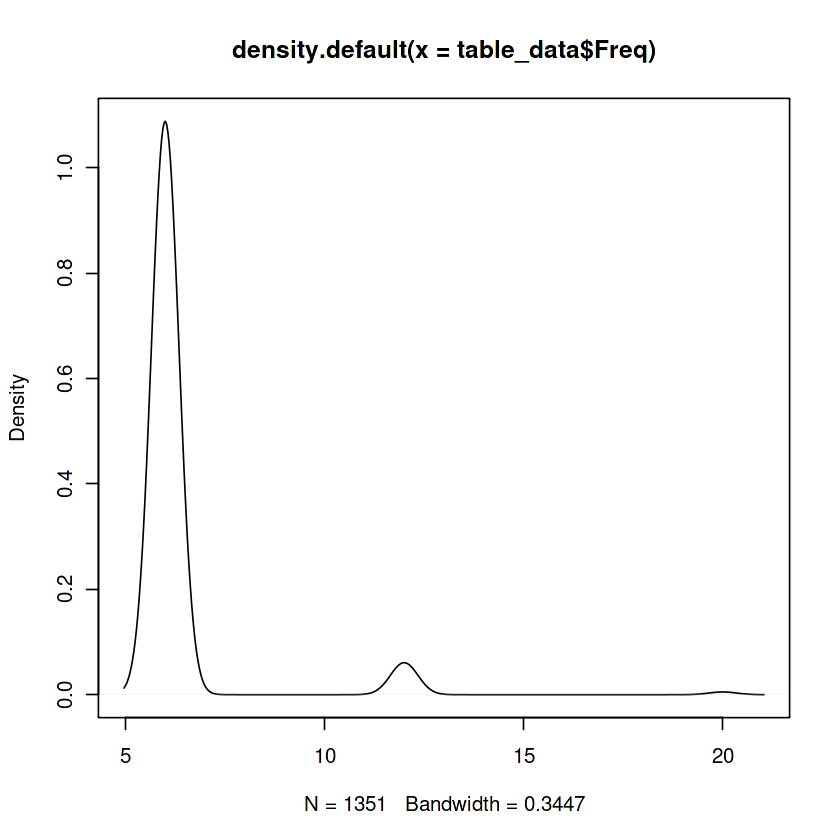

In [124]:
d <- density(table_data$Freq) # returns the density data
plot(d) # plots the results

In [125]:
table_data <- as.data.frame(table(pairwise_pairs_lr$complex_pair))

In [126]:
jpeg(file="Number of binary pairs produced.jpeg")
table_data <- table(pairwise_pairs_lr$complex_pair)
hist(table_data, main = "Number of binary pairs produced from complex", xlab = "# of binary originating from a single complex", ylab = "Count")
dev.off()

png 
  2

In [127]:
table_data <- as.data.frame(table(pt_interactions_lr$complex_pair))

Saving 6.67 x 6.67 in image


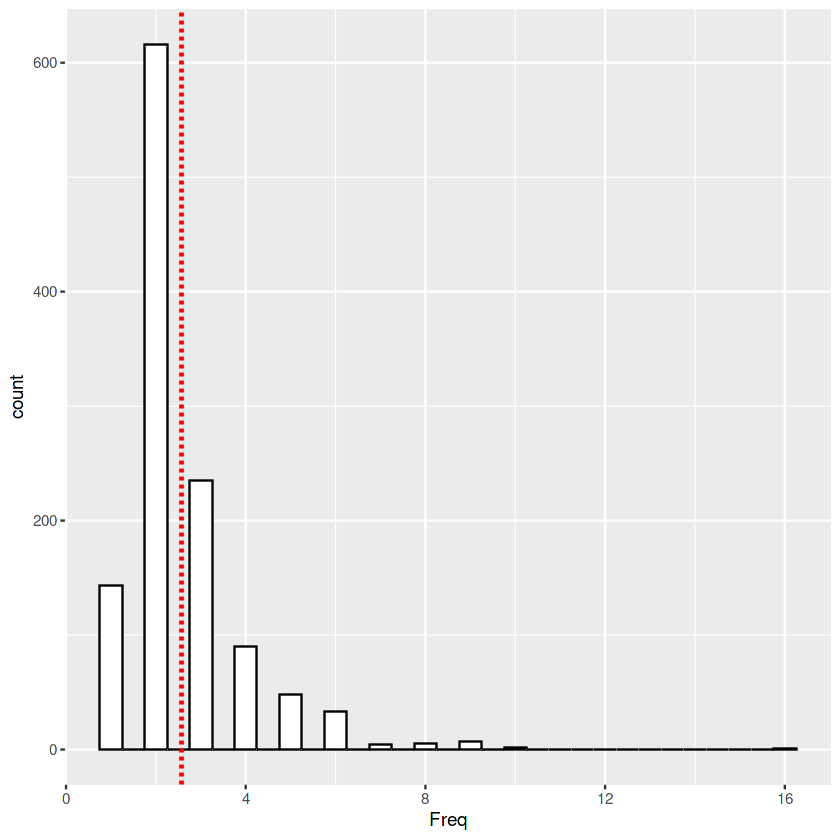

In [128]:
ggplot(table_data, aes(x=Freq)) +
    geom_histogram(binwidth=.5, colour="black", fill="white") +
    geom_vline(aes(xintercept=mean(Freq, na.rm=T)),   # Ignore NA values for mean
               color="red", linetype="dashed", size=1)
ggsave("binaries found.jpeg")

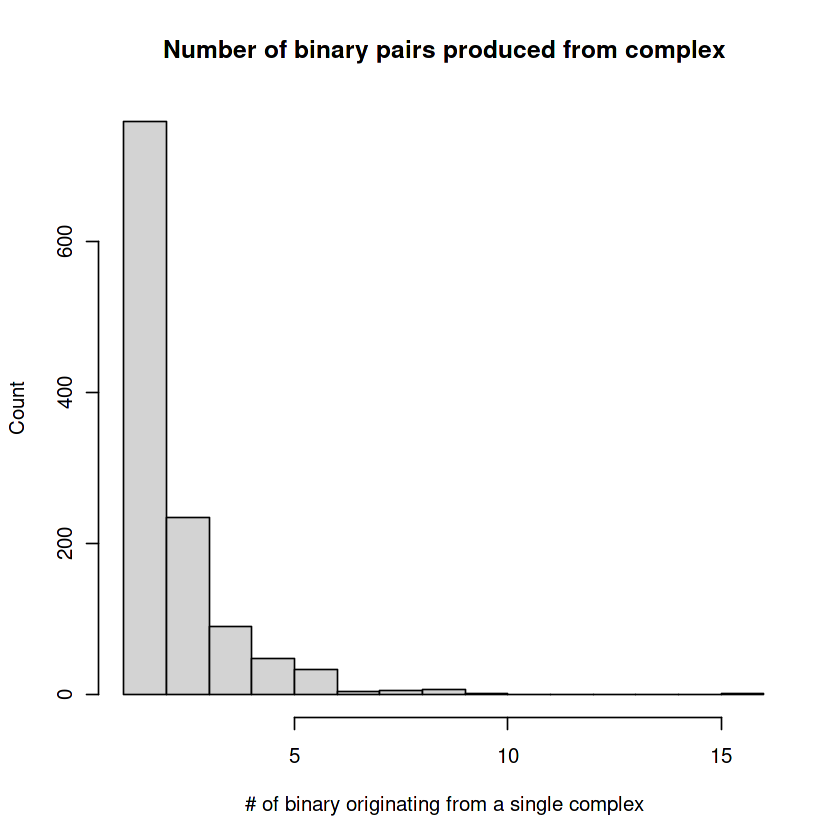

In [129]:
table_data <- table(pt_interactions_lr$complex_pair)
hist(table_data, main = "Number of binary pairs produced from complex", xlab = "# of binary originating from a single complex", ylab = "Count")


# Complexes are broken down, now we can combine with the rest of the db

In [130]:
# This function merges the single components of the complexes that are detected through PPI_DB with 
# the single components of the complexes detected through OmniPath
# The function takes as input the OmniPath data frame and the pt_interactions (which the complex are broken down)

merge_single_complex <- function(OmniPath, pt_interactions){
    single_components = filter(OmniPath, !grepl('COMPLEX', target) & !grepl('COMPLEX',source))
    
    single_components <- single_components %>%
      dplyr::select(source_genesymbol, target_genesymbol) %>%
      dplyr::rename(source=source_genesymbol, target=target_genesymbol) %>%
      dplyr::mutate(complex_pair = NA)    
    
    single_components$pair <- paste(single_components$source, single_components$target, sep="_")
    
    #merge the single ones, with complexes componenets that are detected via PT_DB
    complete <- rbind(single_components, pt_interactions)
    
    #remove the duplicated ones, and drop the last ones, which are coming from the complexes
    complete <- complete[ !duplicated(complete[, "pair"], fromLast=F),]
    
    return(complete)
}

In [131]:
lr_binary=filter(lr, !grepl('COMPLEX', target) & !grepl('COMPLEX',source))

In [132]:
curated_binary=filter(curated, !grepl('COMPLEX', target) & !grepl('COMPLEX',source))

In [133]:
merged=rbind(lr_binary,curated_binary)

In [134]:
merged$pair <- paste(merged$source, merged$target, sep="_")

In [135]:
length(unique(merged$pair))

[1] 6984

In [136]:
lr_complex=filter(lr, grepl('COMPLEX', target) | grepl('COMPLEX',source))

In [137]:
curated_complex=filter(curated, grepl('COMPLEX', target) | grepl('COMPLEX',source))

In [138]:
merged=rbind(lr_complex,curated_complex)
merged$pair <- paste(merged$source, merged$target, sep="_")

In [139]:
length(unique(merged$pair))

[1] 1352

In [140]:
complete_lr <- merge_single_complex(lr, pt_interactions_lr)
complete_curated <- merge_single_complex(curated, pt_interactions_curated)

# Gene Descriptions

We use mygene library to get the gene descriptions

In [141]:
library(mygene)

In [142]:
# map_gene_descriptions function:
# 1. maps gene symbols to gene descriptions using the queryMany function
# 2. maps the protein descriptions to the dataset
# 3. reorders columns and renames columns

map_gene_descriptions <- function(complete) {
    # get gene symbols
    gene_symbols <- unique(c(complete$source,complete$target))
    
    prot_descriptions <- queryMany(gene_symbols, scopes = "symbol", 
                              fields = c("name"), 
                              species = "human", as_dataframe = "True")
    
    prot_descriptions <- as.data.frame(prot_descriptions)
    
    #map protein descriptions to complete set

    for (x in 1:nrow(complete)) {
        ligand_symbol=complete[x,]$source
        receptor_symbol=complete[x,]$target
        ligand_description=filter(prot_descriptions, query==ligand_symbol)$name
        receptor_description=filter(prot_descriptions, query==receptor_symbol)$name
        lig_id=filter(anno_raw, genesymbol==ligand_symbol)$uniprot[1]
        rec_id=filter(anno_raw, genesymbol==receptor_symbol)$uniprot[1]

        if (ligand_symbol=="PIK3CD-AS1") {
          lig_id <- "O00329"
        }

    #     if (is.null(receptor_description)) {
    #       receptor_description <- "NA"
    #     }


        complete[x, "ligand.name"] = ligand_description[1]
        complete[x, "receptor.name"] = receptor_description[1]
        complete[x, "partner_a"] = lig_id
        complete[x, "partner_b"] = rec_id
    }
    
    #reorder columns
    complete <- complete[, c("pair", "source", "ligand.name", "target", "receptor.name", "complex_pair",
                             "partner_a","partner_b")]
    #rename column names
    names(complete) <- c("Pair.Name", "Ligand", "Ligand.Name", "Receptor", "Receptor.Name", "complex_pair",
                        "partner_a","partner_b")
    
    return(complete)
}

In [143]:
complete_lr <- map_gene_descriptions(complete_lr)

Querying chunk 1

Querying chunk 2

Querying chunk 3



Finished
Pass returnall=TRUE to return lists of duplicate or missing query terms.


In [144]:
complete_curated <- map_gene_descriptions(complete_curated)

Querying chunk 1

Querying chunk 2



Finished
Pass returnall=TRUE to return lists of duplicate or missing query terms.


In [145]:
head(complete_curated)

Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
EPO_EPOR,EPO,erythropoietin,EPOR,erythropoietin receptor,NA,P01588,P19235
CXCL16_CXCR6,CXCL16,C-X-C motif chemokine ligand 16,CXCR6,C-X-C motif chemokine receptor 6,NA,Q9H2A7,O00574
KITLG_KIT,KITLG,KIT ligand,KIT,"KIT proto-oncogene, receptor tyrosine kinase",NA,P21583,P10721
CXCL9_CXCR3,CXCL9,C-X-C motif chemokine ligand 9,CXCR3,C-X-C motif chemokine receptor 3,NA,Q07325,P49682
CCL5_CCR5,CCL5,C-C motif chemokine ligand 5,CCR5,C-C motif chemokine receptor 5,NA,P13501,P51681
CCL8_CCR5,CCL8,C-C motif chemokine ligand 8,CCR5,C-C motif chemokine receptor 5,NA,P80075,P51681


In [146]:
# filter(previous_db, Receptor=="NOTCH1")

# append the original structure from OmniPath

In [147]:
lr$pair <- paste(lr$source_genesymbol, lr$target_genesymbol, sep="_")
curated$pair <- paste(curated$source_genesymbol, curated$target_genesymbol, sep="_")

Create a column to merge with. We are doing this because the complex pairs in our data have been broken down, while they are not broken down in the original data. The new column will allow us to match and merge the broken-down pairs with the corresponding pairs in the original data

In [148]:
# If the complex pair is not NA, return the complex pair under the to_merge column. 
# else return the ligand and receptor names separated by an underscore
complete_lr <- complete_lr %>% mutate(to_merge = ifelse(!is.na(complex_pair), complex_pair,
                                                  paste(Ligand, Receptor, sep="_")))

complete_curated <- complete_curated %>% mutate(to_merge = ifelse(!is.na(complex_pair), complex_pair,
                                                  paste(Ligand, Receptor, sep="_")))

In [149]:
# Merge the complete_lr data frame with the lr data frame, using the to_merge column 
# in the former and the pair column in the latter
complete_lr <- as.data.frame(merge(complete_lr, lr, by.x = "to_merge", by.y = "pair"))
complete_curated <- as.data.frame(merge(complete_curated, curated, by.x = "to_merge", by.y = "pair"))

In [150]:
# Remove the columns that were used to merge the data
complete_lr <- complete_lr %>% dplyr::select(-to_merge)
complete_lr$annotation_strategy <- "LR"
complete_curated <- complete_curated %>% dplyr::select(-to_merge)
complete_curated$annotation_strategy <- "curated"

In [252]:
colnames(complete_curated)

[1] "Pair.Name"             "Ligand"                "Ligand.Name"          
 [4] "Receptor"              "Receptor.Name"         "complex_pair"         
 [7] "partner_a"             "partner_b"             "source"               
[10] "target"                "source_genesymbol"     "target_genesymbol"    
[13] "is_directed"           "is_stimulation"        "is_inhibition"        
[16] "consensus_direction"   "consensus_stimulation" "consensus_inhibition" 
[19] "sources"               "references"            "curation_effort"      
[22] "n_references"          "n_resources"           "annotation_strategy"

# tagging curated ones

In [236]:
complete <- rbind(complete_lr, complete_curated)

In [237]:
complete <- complete %>% 
       mutate(db = replace(annotation_strategy, duplicated(Pair.Name) | 
                              duplicated(Pair.Name, fromLast = TRUE), "both"))

In [238]:
complete <- complete %>% filter(!duplicated(complete[, "Pair.Name"]))

In [239]:
lr_final <- filter(complete, db %in% c("LR","both"))

In [240]:
curated_final <- filter(complete, db %in% c("curated","both"))

In [241]:
# curated_final %>% drop_na(complex_pair)

In [242]:
# filter(complete, db=="LR")

In [243]:
#this column is needed when building CellPhoneDB
# concatanated$annotation_strategy <- ifelse(concatanated$curated == TRUE, "OmniPath_curated", "OmniPath")

In [244]:
write.csv(complete, "L_R_reviseD_full_before_fix.csv", row.names=FALSE)

In [245]:
# complete = read.csv('L_R_reviseD_full_before_fix.csv')

In [246]:
filter(complete,Ligand=="PIK3CD-AS1")

Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_direction,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,db
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>
PIK3CD-AS1_LY6G6C,PIK3CD-AS1,PIK3CD antisense RNA 1,LY6G6C,lymphocyte antigen 6 family member G6C,NA,O00329,O95867,Q5SR53,O95867,⋯,0,0,0,Fantom5_LRdb;LRdb;iTALK,NA,0,0,2,LR,LR
PIK3CD-AS1_SLC16A4,PIK3CD-AS1,PIK3CD antisense RNA 1,SLC16A4,solute carrier family 16 member 4,NA,O00329,O15374,Q5SR53,O15374,⋯,0,0,0,Fantom5_LRdb;LRdb;iTALK,NA,0,0,2,LR,LR


In [247]:
complete$Ligand <- str_replace(complete$Ligand, "PIK3CD-AS1", "PIK3CD")

In [248]:
complete$Pair.Name <- paste(complete$Ligand, complete$Receptor, sep="_")

In [249]:
complete$dup <- paste(complete$Receptor, complete$Ligand, sep="_")

In [250]:
complete

Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,db,dup
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>
A2M_LRP1,A2M,alpha-2-macroglobulin,LRP1,LDL receptor related protein 1,NA,P01023,Q07954,P01023,Q07954,⋯,1,0,AlzPathway;Baccin2019;CellTalkDB;EMBRACE;Fantom5_LRdb;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;LRdb;Ramilowski2015;Ramilowski2015_Baccin2019;STRING_talklr;Wang;connectomeDB2020;iTALK;talklr,AlzPathway:19026743;Baccin2019:10652313;Baccin2019:12194978;Baccin2019:1702392;CellTalkDB:10652313;HPRD:10652313;HPRD:12194978;LRdb:10652313;connectomeDB2020:10652313;connectomeDB2020:12194978;connectomeDB2020:1702392,11,4,11,LR,both,LRP1_A2M
AANAT_MTNR1A,AANAT,aralkylamine N-acetyltransferase,MTNR1A,melatonin receptor 1A,NA,Q16613,P48039,Q16613,P48039,⋯,1,0,Baccin2019;CellTalkDB;Fantom5_LRdb;HPMR;HPMR_LRdb;HPMR_talklr;LRdb;Ramilowski2015;Ramilowski2015_Baccin2019;Wang;connectomeDB2020;iTALK;talklr,Baccin2019:12943195;CellTalkDB:12943195;HPMR:12943195;LRdb:12943195;connectomeDB2020:12943195,5,1,9,LR,both,MTNR1A_AANAT
AANAT_MTNR1B,AANAT,aralkylamine N-acetyltransferase,MTNR1B,melatonin receptor 1B,NA,Q16613,P49286,Q16613,P49286,⋯,1,0,Baccin2019;CellTalkDB;Fantom5_LRdb;HPMR_LRdb;HPMR_talklr;LRdb;Ramilowski2015;Ramilowski2015_Baccin2019;Wang;connectomeDB2020;iTALK;talklr,Baccin2019:12943195;CellTalkDB:12943195;LRdb:12943195;connectomeDB2020:12943195,4,1,8,LR,both,MTNR1B_AANAT
ABCA1_SHANK1,ABCA1,ATP binding cassette subfamily A member 1,SHANK1,SH3 and multiple ankyrin repeat domains 1,NA,O95477,Q9Y566,O95477,Q9Y566,⋯,0,0,Baccin2019;HPRD;Ramilowski2015_Baccin2019,HPRD:16192279,1,1,2,LR,LR,SHANK1_ABCA1
ACE_AGTR2,ACE,angiotensin I converting enzyme,AGTR2,angiotensin II receptor type 2,NA,P12821,P50052,P12821,P50052,⋯,0,0,Baccin2019;CellTalkDB;Fantom5_LRdb;HPRD;HPRD_LRdb;HPRD_talklr;LRdb;Ramilowski2015;Ramilowski2015_Baccin2019;iTALK;talklr,Baccin2019:11459796;HPRD:11459796;LRdb:11459796,3,1,7,LR,LR,AGTR2_ACE
ACE_BDKRB2,ACE,angiotensin I converting enzyme,BDKRB2,bradykinin receptor B2,NA,P12821,P30411,P12821,P30411,⋯,0,0,Baccin2019;CellTalkDB;EMBRACE;Fantom5_LRdb;HPRD;HPRD_LRdb;HPRD_talklr;LRdb;Lit-BM-17;Ramilowski2015;Ramilowski2015_Baccin2019;connectomeDB2020;iTALK;talklr,Baccin2019:10748135;CellTalkDB:10748135;HPRD:10748135;LRdb:10748135;Lit-BM-17:17077303;connectomeDB2020:10748135,6,2,10,LR,both,BDKRB2_ACE
ACE2_SLC6A19,ACE2,angiotensin converting enzyme 2,SLC6A19,solute carrier family 6 member 19,NA,Q9BYF1,Q695T7,Q9BYF1,Q695T7,⋯,0,0,CellTalkDB;IntAct,IntAct:32132184;IntAct:34189428,2,2,2,LR,LR,SLC6A19_ACE2
ACE2_TIGIT,ACE2,angiotensin converting enzyme 2,TIGIT,T cell immunoreceptor with Ig and ITIM domains,NA,Q9BYF1,Q495A1,Q9BYF1,Q495A1,⋯,0,0,Cellinker,Cellinker:32589946,1,1,1,LR,LR,TIGIT_ACE2
ACKR1_CCR5,ACKR1,atypical chemokine receptor 1 (Duffy blood group),CCR5,C-C motif chemokine receptor 5,NA,Q16570,P51681,Q16570,P51681,⋯,0,0,Cellinker,Cellinker:29637711,1,1,1,LR,LR,CCR5_ACKR1


# Annotation of components

The Omnipath Intercell annotation database is imported and used to annotate each component. If at least two databases categorize a component as a ligand or receptor, it is annotated as such. If not, we check other possible categories such as extracellular matrix, secreted, and transmembrane. Below is the list of resources used to annotote.

In [166]:
get_intercell_resources()

[1] "Adhesome"             "Almen2009"            "Baccin2019"          
 [4] "CellCall"             "CellCellInteractions" "CellChatDB"          
 [7] "Cellinker"            "CellPhoneDB"          "CellTalkDB"          
[10] "ComPPI"               "connectomeDB2020"     "CSPA"                
[13] "DGIdb"                "EMBRACE"              "GO_Intercell"        
[16] "GPCRdb"               "Guide2Pharma"         "HGNC"                
[19] "HPA_secretome"        "HPMR"                 "ICELLNET"            
[22] "Integrins"            "iTALK"                "Kirouac2010"         
[25] "LOCATE"               "LRdb"                 "Matrisome"           
[28] "MatrixDB"             "MCAM"                 "Membranome"          
[31] "OmniPath"             "OPM"                  "Phobius"             
[34] "Ramilowski_location"  "Ramilowski2015"       "scConnect"           
[37] "SignaLink_function"   "Surfaceome"           "talklr"              
[40] "TopDB"                "UniProt_keyword"      "UniProt_location"    
[43] "UniProt_topology"     "Zhong2015"

In [167]:
# This function is to annotate the components from the PPI network with their parent category
# The input of this function is a df with columns of "genesymbol", "score", "parent"
# The output of this function is a df with columns of "genesymbol", "score", "parent"
# This function is used to annotate the components from the PPI network with their parent category

annotate_components <- function(components) {
    #create a df to store annotation
    df <- data.frame(genesymbol = character(length(components)), score = numeric(length(components)),
                     parent = character(length(components)), stringsAsFactors = FALSE)
    
    # Check if the components are categorized as ligands or receptors
    for (x in 1:length(components)) {
    #     maxvalue=max(filter(anno, uniprot==components[x])$consensus_score)
        genename <- components[x]
        parent_score <- sort(table(filter(anno_lig, genesymbol==components[x])$parent), decreasing = T, na.last = T)[1]
        parent_category <- names(parent_score)

        if (is.null(parent_category)) {
          parent_category <- "NA"
          parent_score <- 0
        }

        df[x, "genesymbol"] <- genename
        df[x, "score"] <- parent_score
        df[x, "parent"] <- parent_category

    #     df$genesymbol[x] <- genename
    #     df$score[x] <- parent_score
    #     df$parent[x] <- parent_category
    }
    
    # If a component is not classified as a ligand or receptor, we may consider other categories such as 
    # extracellular matrix, secreted, and transmembrane.# annotated others such as secreted, ecm etc

    df_na <- filter(df, parent=="NA")$genesymbol

    for (x in 1:length(df_na)) {
    #     maxvalue=max(filter(anno, uniprot==components[x])$consensus_score)
        genesymbol <- df_na[x]
        parent_score <- sort(table(filter(anno_raw, genesymbol==df_na[x])$parent), decreasing = T, na.last = T)[1]
        parent_category <- names(parent_score)

        df <- df %>% mutate(parent = ifelse(genesymbol == df_na[x], parent_category, parent))
        df <- df %>% mutate(score = ifelse(genesymbol == df_na[x], parent_score, score))

    }
    
    # replace ecm and secreted with ligand
    df$parent <- replace(df$parent, df$parent == "ecm", "ligand")
    df$parent <- replace(df$parent, df$parent == "secreted", "ligand")
    
    return(df)

}

In [168]:
components <- unique(c(complete$Ligand, complete$Receptor))

In [169]:
annotation <- annotate_components(components)

In [170]:
unique(annotation$parent)

[1] "ligand"           "intracellular"    "transmembrane"    "receptor"        
 [5] "plasma_membrane"  "ecm_regulator"    "cell_adhesion"    "ligand_regulator"
 [9] "cell_surface"     "gap_junction"

In [171]:
# ggplot(true_LR, aes(x=score)) +
#     geom_histogram(binwidth=.5, colour="black", fill="white") +
#     geom_vline(aes(xintercept=mean(score, na.rm=T)),   # Ignore NA values for mean
#                color="red", linetype="dashed", size=1)

In [172]:
#TRUE LR genespace
true_LR <- filter(annotation, parent == "receptor" | parent == "ligand")
true_LR_genespace <- true_LR$genesymbol

In [173]:
annotation[annotation$genesymbol=="BMPR1B",]

,genesymbol,score,parent
,<chr>,<dbl>,<chr>
63,BMPR1B,20,receptor


In [174]:
adhesive <- filter(annotation, !genesymbol %in% true_LR$genesymbol)

In [175]:
ligands <- filter(true_LR, parent=="ligand")$genesymbol
receptors <- filter(true_LR, parent=="receptor")$genesymbol

In [176]:
# Filter the LR pairs that are not in the correct direction
# Exclude the pairs if the swapped (correct direction) counterparts exist in the database

LR_fix_dir <- complete %>% 
  filter(Ligand %in% receptors & Receptor %in% ligands) #%>% 
  #anti_join(complete, by = c("dup" = "Pair.Name"))
#     filter(!dup %in% complete$Pair.Name)

In [177]:
complete

Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,db,dup
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>
A2M_LRP1,A2M,alpha-2-macroglobulin,LRP1,LDL receptor related protein 1,NA,P01023,Q07954,P01023,Q07954,⋯,1,0,AlzPathway;Baccin2019;CellTalkDB;EMBRACE;Fantom5_LRdb;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;LRdb;Ramilowski2015;Ramilowski2015_Baccin2019;STRING_talklr;Wang;connectomeDB2020;iTALK;talklr,AlzPathway:19026743;Baccin2019:10652313;Baccin2019:12194978;Baccin2019:1702392;CellTalkDB:10652313;HPRD:10652313;HPRD:12194978;LRdb:10652313;connectomeDB2020:10652313;connectomeDB2020:12194978;connectomeDB2020:1702392,11,4,11,LR,both,LRP1_A2M
AANAT_MTNR1A,AANAT,aralkylamine N-acetyltransferase,MTNR1A,melatonin receptor 1A,NA,Q16613,P48039,Q16613,P48039,⋯,1,0,Baccin2019;CellTalkDB;Fantom5_LRdb;HPMR;HPMR_LRdb;HPMR_talklr;LRdb;Ramilowski2015;Ramilowski2015_Baccin2019;Wang;connectomeDB2020;iTALK;talklr,Baccin2019:12943195;CellTalkDB:12943195;HPMR:12943195;LRdb:12943195;connectomeDB2020:12943195,5,1,9,LR,both,MTNR1A_AANAT
AANAT_MTNR1B,AANAT,aralkylamine N-acetyltransferase,MTNR1B,melatonin receptor 1B,NA,Q16613,P49286,Q16613,P49286,⋯,1,0,Baccin2019;CellTalkDB;Fantom5_LRdb;HPMR_LRdb;HPMR_talklr;LRdb;Ramilowski2015;Ramilowski2015_Baccin2019;Wang;connectomeDB2020;iTALK;talklr,Baccin2019:12943195;CellTalkDB:12943195;LRdb:12943195;connectomeDB2020:12943195,4,1,8,LR,both,MTNR1B_AANAT
ABCA1_SHANK1,ABCA1,ATP binding cassette subfamily A member 1,SHANK1,SH3 and multiple ankyrin repeat domains 1,NA,O95477,Q9Y566,O95477,Q9Y566,⋯,0,0,Baccin2019;HPRD;Ramilowski2015_Baccin2019,HPRD:16192279,1,1,2,LR,LR,SHANK1_ABCA1
ACE_AGTR2,ACE,angiotensin I converting enzyme,AGTR2,angiotensin II receptor type 2,NA,P12821,P50052,P12821,P50052,⋯,0,0,Baccin2019;CellTalkDB;Fantom5_LRdb;HPRD;HPRD_LRdb;HPRD_talklr;LRdb;Ramilowski2015;Ramilowski2015_Baccin2019;iTALK;talklr,Baccin2019:11459796;HPRD:11459796;LRdb:11459796,3,1,7,LR,LR,AGTR2_ACE
ACE_BDKRB2,ACE,angiotensin I converting enzyme,BDKRB2,bradykinin receptor B2,NA,P12821,P30411,P12821,P30411,⋯,0,0,Baccin2019;CellTalkDB;EMBRACE;Fantom5_LRdb;HPRD;HPRD_LRdb;HPRD_talklr;LRdb;Lit-BM-17;Ramilowski2015;Ramilowski2015_Baccin2019;connectomeDB2020;iTALK;talklr,Baccin2019:10748135;CellTalkDB:10748135;HPRD:10748135;LRdb:10748135;Lit-BM-17:17077303;connectomeDB2020:10748135,6,2,10,LR,both,BDKRB2_ACE
ACE2_SLC6A19,ACE2,angiotensin converting enzyme 2,SLC6A19,solute carrier family 6 member 19,NA,Q9BYF1,Q695T7,Q9BYF1,Q695T7,⋯,0,0,CellTalkDB;IntAct,IntAct:32132184;IntAct:34189428,2,2,2,LR,LR,SLC6A19_ACE2
ACE2_TIGIT,ACE2,angiotensin converting enzyme 2,TIGIT,T cell immunoreceptor with Ig and ITIM domains,NA,Q9BYF1,Q495A1,Q9BYF1,Q495A1,⋯,0,0,Cellinker,Cellinker:32589946,1,1,1,LR,LR,TIGIT_ACE2
ACKR1_CCR5,ACKR1,atypical chemokine receptor 1 (Duffy blood group),CCR5,C-C motif chemokine receptor 5,NA,Q16570,P51681,Q16570,P51681,⋯,0,0,Cellinker,Cellinker:29637711,1,1,1,LR,LR,CCR5_ACKR1


In [178]:
annotation[annotation$genesymbol=="BMP15",]

,genesymbol,score,parent
,<chr>,<dbl>,<chr>
122,BMP15,18,ligand


In [179]:
complete <- filter(complete, !Pair.Name %in% LR_fix_dir$Pair.Name)

In [180]:
7415 - nrow(complete)

[1] 395

In [181]:
#fix the directions
LR_fix_dir[, c("Ligand", "Receptor", "Ligand.Name", "Receptor.Name",
      "partner_a","partner_b", "source","target","source_genesymbol","target_genesymbol")] <- LR_fix_dir[, c("Receptor", "Ligand", "Receptor.Name", "Ligand.Name",
                                                                                                    "partner_b","partner_a", "target","source","target_genesymbol","source_genesymbol")]

LR_fix_dir["Pair.Name"] <- paste(LR_fix_dir$Ligand, LR_fix_dir$Receptor, sep="_")
LR_fix_dir["dup"] <- paste(LR_fix_dir$Receptor, LR_fix_dir$Ligand, sep="_")

In [182]:
# these are the list of interactions that are strictly in LR direction
true_LR_DB <- complete %>% filter(Ligand %in% ligands & Receptor %in% receptors)

In [183]:
true_LR_DB["True_LR"]=TRUE

In [184]:
LR_fix_dir["True_LR"]=TRUE

In [185]:
true_LR_DB <- rbind(true_LR_DB,LR_fix_dir)

In [186]:
adhesive_DB <- filter(complete, !Pair.Name %in% true_LR_DB$Pair.Name)

In [187]:
adhesive_DB["True_LR"]=FALSE

In [188]:
reversed <- complete[complete$dup %in% complete$Pair.Name,  ]

In [189]:
found_in_LR <- filter(reversed, dup %in% true_LR_DB$Pair.Name)

In [190]:
reversed <- filter(reversed, !Pair.Name %in% found_in_LR$Pair.Name)
reversed <- filter(reversed, !Pair.Name %in% found_in_LR$dup)

In [191]:
adhesive_DB  <- filter(adhesive_DB, !Pair.Name %in% found_in_LR$Pair.Name)
adhesive_DB  <- filter(adhesive_DB, !dup %in% found_in_LR$dup)

In [192]:
# reversed <- adhesive_DB[adhesive_DB$dup %in% adhesive_DB$Pair.Name,  ]

In [193]:
# adhesive_DB <- adhesive_DB[!adhesive_DB$dup %in% true_LR_DB$Pair.Name,  ]

In [194]:
2705 - 2613

[1] 92

In [195]:
# remove the subsetted partition from the original df
adhesive_DB <- adhesive_DB[!adhesive_DB$Pair.Name %in% reversed$Pair.Name,  ]

In [196]:
# true_LR_DB <- filter(true_LR_DB, !Pair.Name %in% reversed_found_in_LR$dup)

In [197]:
# Subset the LR_database data frame to only include rows where we have swapped interactions

subset_lr <- reversed

In [198]:
nrow(subset_lr)

[1] 342

In [199]:
nrow(adhesive_DB)

[1] 2613

In [200]:
# Extract all the unique proteins/genes from the subset_lr data frame that have "plexin",
# "neuroligin" or "ADAM" in their Receptor.Name column
# these will be corrected as ligands

plexin_family <- as.vector(subset_lr[grep("plexin", subset_lr$Receptor.Name), ]$Receptor)

neuroligin_family <- as.vector(subset_lr[grep("neuroligin", subset_lr$Receptor.Name), ]$Receptor)

adam_family <- as.vector(subset_lr[grep("ADAM", subset_lr$Receptor.Name), ]$Receptor)

#extract receptors that has annotation of "receptor" under Ligand.Name
receptor_anno <- as.vector(subset_lr[grep("receptor", subset_lr$Ligand.Name), ]$Ligand)

In [201]:
ligand <- c("AGRN", "BMP2", "BMP4", "VTCN1", "CD244", "CD38", "GAS6", "GDNF", "GUCA2A", 
"HHLA2", "IHH", "PSEN1", "NLGN", "NRTN", "RPH3A", "SHH","FLT3LG")

receptor <- c("CD2", "CD27", "CD80", "CD86", "SELL", "CD44", "CD81", "CD8A", "CLEC1B", 
"GLG1", "TYROBP", "FLT3", "ERBB2", "EGFR", "IL1R1", "IL1RAP", "KDR", "NRP1")

In [202]:
# Combine the additional ligands with the plexin, neuroligin, and ADAM families into a vector called ligand
ligand <- unique(c(ligand,plexin_family,neuroligin_family,adam_family))
receptor <- unique(c(receptor,receptor_anno))

In [203]:
# Subset the subset_lr data frame to only include rows where the consensus_direction column is 1
dir <- subset_lr %>% filter(Pair.Name %in% subset_lr$dup & consensus_direction == 1)

In [204]:
# Subset the subset_lr data frame to only include rows where the consensus_direction column is 0
no_dir <- subset_lr %>% filter(Pair.Name %in% subset_lr$dup & consensus_direction == 0)

In [205]:
nrow(no_dir)

[1] 287

In [206]:
nrow(dir)

[1] 55

In [207]:
# Remove rows from no_dir where the pair is already present in dir
in_dir <- dir[dir$dup %in% no_dir$Pair.Name,] 
no_dir <- no_dir[!no_dir$Pair.Name %in% dir$dup,  ] #removal of those in dir below is rm of nodir
# dir <- dir[!dir$Pair.Name %in% in_dir$Pair.Name,] # did not work thats why there is below no fucking idea

In [208]:
x <- dir[!dir$Pair.Name %in% in_dir$Pair.Name,]

In [209]:
dir<-x

In [210]:
# remove the interactions where receptor is annotated as ligand
wrong_lig <- no_dir[no_dir$Receptor %in% ligand,]
correct_lig <- no_dir[no_dir$dup %in% wrong_lig$Pair.Name,]
no_dir <- no_dir[!no_dir$Pair.Name %in% c(wrong_lig$Pair.Name, correct_lig$Pair.Name),]

In [211]:
wrong_rec <- no_dir[no_dir$Ligand %in% receptor,]
wrong_rec <- wrong_rec[!wrong_rec$Pair.Name %in% wrong_rec$dup,]

In [212]:
# remove the interactions where receptor is annotated as ligand
wrong_rec <- no_dir[no_dir$Ligand %in% receptor,]
wrong_rec <- wrong_rec[!wrong_rec$Pair.Name %in% wrong_rec$dup,]
correct_rec <- no_dir[no_dir$dup %in% wrong_rec$Pair.Name,]
no_dir <- no_dir[!no_dir$Pair.Name %in% c(wrong_rec$Pair.Name, correct_rec$Pair.Name),]

In [213]:
nrow(no_dir)

[1] 114

In [214]:
# remove the interactions where receptor is annotated as ligand
# no_dir <- no_dir[!no_dir$Receptor %in% ligand,]

In [215]:
# remove the interactions where ligand is annotated as receptor
# no_dir <- no_dir[!no_dir$Ligand %in% receptor,]

In [216]:
# wrong_lig <- no_dir[no_dir$Receptor %in% ligand,]

In [217]:
# Create an empty data frame called df with the same column names as no_dir
df <- data.frame(matrix(ncol = ncol(no_dir), nrow = 0))
x <- colnames(no_dir)
colnames(df) <- x

In [218]:
# Loop through unique ligands in the no_dir data frame
for (lig in unique(no_dir$Ligand)) {
    vec_clean <- vector()
    # Filter the no_dir data frame to include only rows where Ligand or Receptor column matches the current ligand in the loop
    # this yields the pairs that are swapped.
    r1 <- filter(no_dir, Ligand==lig | Receptor == lig)
#     print(lig)
#     print(nrow(r1))
    vec <- r1$Pair.Name
    
    for (component in vec) {
        comp <- unlist(strsplit(component, split = "_"))
        pair1 <- paste(comp[1], comp[2], sep = "_")
        pair2 <- paste(comp[2], comp[1], sep = "_")
        
        if (!pair1 %in% vec_clean & !pair2 %in% vec_clean) {
            vec_clean <- append(vec_clean, pair1)
        }
    }
    
    # Filter the r1 data frame to include only the unique pairs in vec_clean and append the resulting data frame to df
    c1 <- r1[r1$Pair.Name %in% vec_clean,]
    
    df <- rbind(df,c1)
}

In [219]:
no_dir_df <- df[!duplicated(df$Pair.Name),]

In [220]:
nrow(no_dir_df)

[1] 57

In [221]:
# Combine the dir and no_dir_df data frames
subset_lr <- rbind(dir,no_dir_df,in_dir,correct_lig,correct_rec)

In [222]:
subset_lr["True_LR"] <- FALSE

In [223]:
# Add the remaining rows of LR_database to subset_lr
adhesive_DB <- rbind(subset_lr,adhesive_DB)

In [224]:
dir_fix <- c("ERBB2_EGFR", "IL1RAP_IL1R1", "NRP1_KDR")

In [225]:
adhesive_DB <- adhesive_DB[!adhesive_DB$Pair.Name %in% dir_fix,  ]

In [226]:
# adhesive_DB <- adhesive_DB[,!names(adhesive_DB) == "dup"]

In [227]:
# found_in_LR["True_LR"]<- TRUE

In [228]:
LR_database <- rbind(true_LR_DB, adhesive_DB,found_in_LR)

In [229]:
LR_database <- LR_database[!LR_database$Pair.Name %in% found_in_LR$dup,]

In [230]:
LR_database <- LR_database[!duplicated(LR_database$Pair.Name),]

In [232]:
#update the complex_pair columns
all_pairwise <- rbind(pairwise_pairs_curated, pairwise_pairs_lr)
all_pairwise <- all_pairwise[!duplicated(all_pairwise$pair),]
colnames(all_pairwise)[4] <- "Pair.Name"



LR_database <- LR_database %>%
  mutate(complex_pair = coalesce(all_pairwise$complex_pair[match(Pair.Name, all_pairwise$Pair.Name)], complex_pair))

In [234]:
LR_database <- LR_database[,!names(LR_database) == "dup"]

In [235]:
LR_database

,Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,db,True_LR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>
1,A2M_LRP1,A2M,alpha-2-macroglobulin,LRP1,LDL receptor related protein 1,NA,P01023,Q07954,P01023,Q07954,⋯,1,0,AlzPathway;Baccin2019;CellTalkDB;EMBRACE;Fantom5_LRdb;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;LRdb;Ramilowski2015;Ramilowski2015_Baccin2019;STRING_talklr;Wang;connectomeDB2020;iTALK;talklr,AlzPathway:19026743;Baccin2019:10652313;Baccin2019:12194978;Baccin2019:1702392;CellTalkDB:10652313;HPRD:10652313;HPRD:12194978;LRdb:10652313;connectomeDB2020:10652313;connectomeDB2020:12194978;connectomeDB2020:1702392,11,4,11,LR,both,TRUE
2,ACTR2_ADRB2,ACTR2,actin related protein 2,ADRB2,adrenoceptor beta 2,NA,P61160,P07550,P61160,P07550,⋯,0,0,CellTalkDB;LRdb;Reactome_LRdb,CellTalkDB:32196115,1,1,2,LR,both,TRUE
3,ACTR2_LDLR,ACTR2,actin related protein 2,LDLR,low density lipoprotein receptor,NA,P61160,P01130,P61160,P01130,⋯,0,0,CellTalkDB;LRdb;Reactome_LRdb,CellTalkDB:32196115,1,1,2,LR,both,TRUE
4,ACTR2_LRP2,ACTR2,actin related protein 2,LRP2,LDL receptor related protein 2,NA,P61160,P98164,P61160,P98164,⋯,0,0,CellTalkDB;LRdb;Reactome_LRdb,CellTalkDB:32196115,1,1,2,LR,both,TRUE
5,ADAM11_CCR4,ADAM11,ADAM metallopeptidase domain 11,CCR4,C-C motif chemokine receptor 4,NA,O75078,P51679,O75078,P51679,⋯,1,0,Kirouac2010,NA,0,0,1,LR,LR,TRUE
6,ADAM11_ITGA4,ADAM11,ADAM metallopeptidase domain 11,ITGA4,integrin subunit alpha 4,NA,O75078,P13612,O75078,P13612,⋯,0,0,connectomeDB2020,connectomeDB2020:28913673,1,1,1,LR,both,TRUE
7,ADCYAP1_ADCYAP1R1,ADCYAP1,adenylate cyclase activating polypeptide 1,ADCYAP1R1,ADCYAP receptor type I,NA,P18509,P41586,P18509,P41586,⋯,1,0,Baccin2019;CellCall;CellChatDB;CellPhoneDB;CellTalkDB;Cellinker;DIP;EMBRACE;Fantom5_LRdb;Guide2Pharma;Guide2Pharma_LRdb;Guide2Pharma_talklr;HPMR;HPMR_Cellinker;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;I2D_CellPhoneDB;IMEx_CellPhoneDB;LRdb;Ramilowski2015;Ramilowski2015_Baccin2019;Reactome_LRdb;SIGNOR;Wang;connectomeDB2020;iTALK;scConnect;talklr,Baccin2019:10100920;Baccin2019:10583729;Baccin2019:11931347;Baccin2019:16930633;Baccin2019:8253796;Baccin2019:8703026;CellChatDB:21350482;CellTalkDB:10100920;Cellinker:10100920;Cellinker:10583729;Cellinker:11931347;Cellinker:12488235;Cellinker:16930633;Cellinker:21350482;Cellinker:8253796;Cellinker:8703026;DIP:17470806;Guide2Pharma:10583729;Guide2Pharma:11931347;Guide2Pharma:16930633;HPMR:10100920;HPRD:10583729;HPRD:8253796;LRdb:10100920;LRdb:10583729;LRdb:11931347;LRdb:16930633;LRdb:8253796;LRdb:8703026;SIGNOR:8703026;connectomeDB2020:10100920;connectomeDB2020:10583729;connectomeDB2020:11931347;connectomeDB2020:16930633;connectomeDB2020:8253796;connectomeDB2020:8703026;scConnect:10583729;scConnect:11931347;scConnect:16930633,39,9,19,LR,both,TRUE
8,ADCYAP1_ADRB2,ADCYAP1,adenylate cyclase activating polypeptide 1,ADRB2,adrenoceptor beta 2,NA,P18509,P07550,P18509,P07550,⋯,0,0,CellTalkDB;LRdb;Reactome_LRdb,CellTalkDB:32196115,1,1,2,LR,both,TRUE
9,ADCYAP1_ADRB3,ADCYAP1,adenylate cyclase activating polypeptide 1,ADRB3,adrenoceptor beta 3,NA,P18509,P13945,P18509,P13945,⋯,0,0,CellTalkDB;LRdb;Reactome_LRdb,CellTalkDB:32196115,1,1,2,LR,both,TRUE


In [413]:
write.csv(LR_database, "LR_database.csv", row.names=FALSE)

In [414]:
save(LR_database, file = "LR_database.rda")